In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Load data
loaded_df = pd.read_hdf('../data/sample_otu_arrays.h5', key='df')

# Set random seed
np.random.seed(42)

# Split indices into train/test
train_idx, test_idx = train_test_split(loaded_df.index, test_size=0.2, random_state=42)

# Create train and test dataframes
train_df = loaded_df.loc[train_idx]
test_df = loaded_df.loc[test_idx]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print("\nFirst few training samples:")
print(train_df.head())

# Let's also look at array lengths
array_lengths = [len(x) for x in loaded_df['otu_arrays']]
print(f"\nMin array length: {min(array_lengths)}")
print(f"Max array length: {max(array_lengths)}")
print(f"Mean array length: {np.mean(array_lengths):.2f}")

Train size: 6486
Test size: 1622

First few training samples:
                                                            otu_arrays
Unnamed: 0                                                            
SRR044975.SRS011167  [30, 58, 82, 89, 93, 98, 99, 104, 117, 120, 12...
SRR049604.SRS049164  [9, 10, 11, 14, 15, 16, 17, 20, 28, 30, 31, 32...
SRR331714.SRS076947  [19, 30, 43, 58, 65, 70, 71, 74, 80, 90, 92, 9...
SRR089999.SRS077685  [12, 14, 18, 20, 22, 38, 45, 67, 68, 76, 88, 1...
SRR048091.SRS021563  [19, 30, 45, 52, 58, 60, 65, 70, 74, 80, 90, 9...

Min array length: 3
Max array length: 277
Mean array length: 69.10


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class OTUDataset(Dataset):
    def __init__(self, df, pad_token_id=0):
        self.df = df
        self.pad_token_id = pad_token_id
        
        # Find max sequence length for padding
        self.max_len = max(len(x) for x in df['otu_arrays'])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        array = self.df.iloc[idx]['otu_arrays']
        
        # Create padded sequence
        padded = torch.full((self.max_len,), self.pad_token_id, dtype=torch.long)
        padded[:len(array)] = torch.tensor(array, dtype=torch.long)
        
        # Create padding mask (False for real tokens, True for padding)
        # This matches the convention used in transformers where
        # True indicates positions that should be masked
        padding_mask = torch.zeros(self.max_len, dtype=torch.bool)
        padding_mask[len(array):] = True
        
        return {
            'input_ids': padded,
            'padding_mask': padding_mask,
            'seq_len': len(array)
        }

# Create datasets
train_dataset = OTUDataset(train_df, pad_token_id=0)
test_dataset = OTUDataset(test_df, pad_token_id=0)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify shapes
for i in train_loader:
   print(i['input_ids'].shape)
   print(i['padding_mask'].shape)
   print(i['seq_len'])
   break

# Get vocab size (maximum token ID + 1 for padding)
vocab_size = max(max(x) for x in loaded_df['otu_arrays']) + 1
print(f"\nVocabulary size: {vocab_size}")

torch.Size([32, 277])
torch.Size([32, 277])
tensor([101,  94,  44,  71,  37,  37, 106,  60,  47, 138,  53,  99,  68,  22,
         89,  28,  34,  74,  79,  98, 119,  21, 169,  92,  79,  55,  51,  65,
         59,  75,  46,  47])

Vocabulary size: 519


In [4]:
import importlib
import cdcdModel
import scheduler
importlib.reload(cdcdModel)
importlib.reload(scheduler)

from cdcdModel import CDCDModel
from scheduler import AdaptiveSchedule

In [5]:
def train_step(model, batch, scheduler, optimizer):
    """Single training step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing:
            - input_ids: [batch_size, seq_len] tensor of token ids
            - padding_mask: [batch_size, seq_len] boolean tensor (True for padding)
        scheduler: AdaptiveSchedule instance
        optimizer: PyTorch optimizer
    
    Returns:
        loss: scalar training loss
        entropy: entropy statistics for scheduler
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Sample random timesteps for training
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)  # Shape: [batch_size]
   
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=True,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is pad_token_id
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy for scheduler
    with torch.no_grad():
        probs = F.softmax(logits, dim=-1)
        
        # Add small epsilon to prevent log(0)
        eps = 1e-8
        probs = torch.clamp(probs, min=eps, max=1-eps)
        
        entropy = -(probs * torch.log(probs)).sum(dim=-1)  # [batch_size, seq_len]
        
        # Expand timesteps to match sequence dimension
        timesteps_expanded = timesteps.unsqueeze(-1).expand(-1, seq_len)
        
        # Add entropy data to scheduler (excluding padding)
        scheduler.add_data(
            entropy[~padding_mask],
            timesteps_expanded[~padding_mask],
            padding_mask=None  # Already filtered padding
        )
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.mean().item()

def eval_step(model, batch):
    """Single evaluation step for CDCD model
    
    Args:
        model: CDCDModel instance
        batch: Dictionary containing input_ids and padding_mask
        
    Returns:
        loss: scalar evaluation loss
        entropy: entropy statistics
    """
    # Get batch data
    input_ids = batch['input_ids']
    padding_mask = batch['padding_mask']
    batch_size, seq_len = input_ids.shape
    
    # Use middle timestep for evaluation (or could sample uniformly)
    timesteps = scheduler.sample((batch_size,)).to(input_ids.device)
    
    # Forward pass through model
    logits = model(
        input_ids,
        timesteps=timesteps,
        training=False,
        padding_mask=padding_mask
    )
    
    # Calculate cross entropy loss (ignoring padding)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(
        logits.view(-1, logits.size(-1)),
        input_ids.view(-1)
    )
    
    # Calculate entropy
    probs = F.softmax(logits, dim=-1)
    eps = 1e-8
    probs = torch.clamp(probs, min=eps, max=1-eps)
    entropy = -(probs * torch.log(probs)).sum(dim=-1)
    
    return loss.item(), entropy.mean().item()

In [6]:
def run_epoch(model, dataloader, scheduler, optimizer, train_run=True, epoch_num=None):
    """Runs one epoch of training or evaluation for the CDCD model"""
    model.train() if train_run else model.eval()
    total_loss = 0
    total_entropy = 0
    num_batches = 0
    
    # Setup progress bar
    mode = "Train" if train_run else "Eval"
    epoch_str = f"Epoch {epoch_num}" if epoch_num is not None else mode
    pbar = tqdm(total=len(dataloader), desc=f"{epoch_str} Loss: 0.0000, Entropy: 0.0000")
    device = next(model.parameters()).device

    # Main loop
    for batch in dataloader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        if train_run:
            loss, entropy = train_step(model, batch, scheduler, optimizer)
        else:
            # Use separate eval step without optimizer/scheduler
            loss, entropy = eval_step(model, batch)
        
        # Accumulate metrics
        total_loss += loss
        total_entropy += entropy
        num_batches += 1
        
        # Update progress bar
        avg_loss = total_loss / num_batches
        avg_entropy = total_entropy / num_batches
        pbar.set_description(f"{epoch_str} Loss: {avg_loss:.4f}, Entropy: {avg_entropy:.4f}")
        pbar.update(1)
    
    pbar.close()
    
    # Calculate final averages
    avg_loss = total_loss / num_batches
    avg_entropy = total_entropy / num_batches
    
    # Update scheduler parameters if training
    if train_run:
        scheduler.update_optimal_parameters(history=10_000)
    
    return {
        "loss": avg_loss,
        "entropy": avg_entropy,
        "num_batches": num_batches
    }

In [7]:
def train(
    model,
    train_dataloader,
    eval_dataloader,
    noise_scheduler,
    num_epochs,
    initial_lr=1e-4,
    min_lr=1e-6,
    first_cycle_epochs=30,
    cycle_mult=2,
    eval_every=1,
    early_stopping_patience=5,
    save_dir="checkpoints",
    device="cuda",
):
    """Trains the CDCD model using Cosine Annealing with Warm Restarts
    
    Args:
        model: CDCDModel instance
        train_dataloader: DataLoader for training data
        eval_dataloader: DataLoader for evaluation data
        noise_scheduler: Noise scheduler for diffusion process
        num_epochs: Number of epochs to train for
        initial_lr: Initial learning rate
        min_lr: Minimum learning rate
        first_cycle_epochs: Length of first cosine cycle
        cycle_mult: Factor to multiply cycle length by after each restart
        eval_every: Number of epochs between evaluation runs
        early_stopping_patience: Number of epochs to wait for improvement before stopping
        save_dir: Directory to save model checkpoints
        device: Device to train on
    """
    import torch
    from torch.optim import lr_scheduler
    from pathlib import Path
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr)
    lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=first_cycle_epochs,
        T_mult=cycle_mult,
        eta_min=min_lr
    )
    
    best_eval_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0
    train_losses = []
    eval_losses = []
    learning_rates = []
    
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        train_metrics = run_epoch(
            model=model,
            dataloader=train_dataloader,
            scheduler=noise_scheduler,
            optimizer=optimizer,
            train_run=True,
            epoch_num=epoch+1
        )
        train_losses.append(train_metrics['loss'])
        
        # Evaluation phase
        if (epoch + 1) % eval_every == 0:
            eval_metrics = run_epoch(
                model=model,
                dataloader=eval_dataloader,
                scheduler=noise_scheduler,
                optimizer=optimizer,
                train_run=False,
                epoch_num=epoch+1
            )
            eval_losses.append(eval_metrics['loss'])
            
            # Save best model and handle early stopping
            if eval_metrics['loss'] < best_eval_loss:
                best_eval_loss = eval_metrics['loss']
                best_epoch = epoch
                epochs_without_improvement = 0
                
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': lr_scheduler.state_dict(),
                    'noise_scheduler_state': noise_scheduler.state_dict(),
                    'loss': best_eval_loss,
                }, save_dir / 'best_model.pt')
            else:
                epochs_without_improvement += 1
            
            print(f"Eval Loss: {eval_metrics['loss']:.4f}")
            print(f"Best Loss: {best_eval_loss:.4f} (Epoch {best_epoch+1})")
            
            if epochs_without_improvement >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break
        
        # Update learning rate
        lr_scheduler.step()
        learning_rates.append(current_lr)
        
        # Save periodic checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'noise_scheduler_state': noise_scheduler.state_dict(),
                'loss': train_metrics['loss'],
            }, save_dir / f'checkpoint_epoch_{epoch+1}.pt')
    
    # Load best model
    best_checkpoint = torch.load(save_dir / 'best_model.pt')
    model.load_state_dict(best_checkpoint['model_state_dict'])
    
    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'best_epoch': best_epoch,
        'learning_rates': learning_rates
    }

In [8]:
# Model hyperparameters
hidden_dim = 32  # Dimension of hidden layers
embedding_dim = 32  # Dimension of embeddings
num_heads = 8  # Number of attention heads
num_layers = 4  # Number of transformer layers
time_embed_dim = 32  # Dimension of time embeddings
t_min = 1 # Minimum time value
t_max = 25  # To high breaks scheduler. This value really depends on embed dim: SNR = ed/t^2. if ed = 32, tmax=25 ~ 0 SNR
vocab_size = 519

model = CDCDModel(
    hidden_dim = hidden_dim,
    embedding_dim = embedding_dim,
    num_heads = num_heads,
    num_layers = num_layers,
    time_embed_dim = time_embed_dim,
    t_min = t_min,
    t_max = t_max,
    vocab_size = vocab_size,
    dropout=0.1,
    pad_token_id=0
)

scheduler = AdaptiveSchedule(
    tmin = t_min,
    tmax = t_max,
    mu = 150,
    sigma = 50,
    height = 1,
    offset = 0.1
)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [20]:

for batch in train_loader:
# Move batch to device
    batch = {k: v.to(device) for k, v in batch.items()}
    train_step(model,batch, scheduler, optimizer)
    break

In [10]:
training_history = train(
    model=model,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    noise_scheduler=scheduler,
    num_epochs=20,
    initial_lr=1e-3,
    min_lr=1e-6,
    first_cycle_epochs=4,  # Length of first cosine cycle
    cycle_mult=2,  # Each subsequent cycle is twice as long
    eval_every=1,
    early_stopping_patience=5,
    save_dir="checkpoints"
)


Epoch 1/20 - Learning Rate: 0.001000


Epoch 1 Loss: 5.6158, Entropy: 6.0670: 100%|██████████| 203/203 [00:06<00:00, 33.15it/s]
2025-02-11 12:01:08,147 - INFO - Updated optimal parameters: mu=0.5371774921311312, sigma=1.0624128596840416, height=5.717506033890082, offset=-0.10241638234838735
Epoch 1 Loss: 4.1840, Entropy: 5.7321: 100%|██████████| 51/51 [00:00<00:00, 112.54it/s]


Eval Loss: 4.1840
Best Loss: 4.1840 (Epoch 1)

Epoch 2/20 - Learning Rate: 0.000854


Epoch 2 Loss: 2.9005, Entropy: 5.4011: 100%|██████████| 203/203 [00:05<00:00, 37.87it/s]
2025-02-11 12:01:14,031 - INFO - Updated optimal parameters: mu=1.905910084394623, sigma=1.0531805913314602, height=7.681234762962576, offset=-1.7330694972002123
Epoch 2 Loss: 3.3127, Entropy: 5.2268: 100%|██████████| 51/51 [00:00<00:00, 111.05it/s]


Eval Loss: 3.3127
Best Loss: 3.3127 (Epoch 2)

Epoch 3/20 - Learning Rate: 0.000501


Epoch 3 Loss: 2.9058, Entropy: 5.3744: 100%|██████████| 203/203 [00:05<00:00, 38.29it/s]
2025-02-11 12:01:19,909 - INFO - Updated optimal parameters: mu=2.0859629335816576, sigma=0.96189892687899, height=6.922572241169401, offset=-1.2343085654114798
Epoch 3 Loss: 3.3005, Entropy: 5.1638: 100%|██████████| 51/51 [00:00<00:00, 118.05it/s]


Eval Loss: 3.3005
Best Loss: 3.3005 (Epoch 3)

Epoch 4/20 - Learning Rate: 0.000147


Epoch 4 Loss: 2.8803, Entropy: 5.3658: 100%|██████████| 203/203 [00:05<00:00, 38.40it/s]
2025-02-11 12:01:25,672 - INFO - Updated optimal parameters: mu=2.367702377243396, sigma=1.45761463219317, height=6.795239238095882, offset=-0.8052516712643805
Epoch 4 Loss: 3.7482, Entropy: 5.3364: 100%|██████████| 51/51 [00:00<00:00, 117.44it/s]


Eval Loss: 3.7482
Best Loss: 3.3005 (Epoch 3)

Epoch 5/20 - Learning Rate: 0.001000


Epoch 5 Loss: 3.4361, Entropy: 5.5049: 100%|██████████| 203/203 [00:05<00:00, 38.39it/s]
2025-02-11 12:01:31,415 - INFO - Updated optimal parameters: mu=2.2379457658931985, sigma=1.162422836534541, height=7.023540575547583, offset=-1.1936008897666222
Epoch 5 Loss: 3.6220, Entropy: 5.4224: 100%|██████████| 51/51 [00:00<00:00, 118.22it/s]


Eval Loss: 3.6220
Best Loss: 3.3005 (Epoch 3)

Epoch 6/20 - Learning Rate: 0.000962


Epoch 6 Loss: 3.1375, Entropy: 5.4313: 100%|██████████| 203/203 [00:05<00:00, 38.45it/s]
2025-02-11 12:01:37,142 - INFO - Updated optimal parameters: mu=2.184282283642815, sigma=1.1614730914470797, height=6.854239488878898, offset=-1.0710137026105389
Epoch 6 Loss: 3.4945, Entropy: 5.2150: 100%|██████████| 51/51 [00:00<00:00, 116.79it/s]


Eval Loss: 3.4945
Best Loss: 3.3005 (Epoch 3)

Epoch 7/20 - Learning Rate: 0.000854


Epoch 7 Loss: 3.1071, Entropy: 5.4201: 100%|██████████| 203/203 [00:05<00:00, 37.08it/s]
2025-02-11 12:01:43,071 - INFO - Updated optimal parameters: mu=2.322961465443028, sigma=1.1840304504606665, height=6.553817822170543, offset=-0.730938270489492
Epoch 7 Loss: 3.5048, Entropy: 5.2793: 100%|██████████| 51/51 [00:00<00:00, 115.16it/s]


Eval Loss: 3.5048
Best Loss: 3.3005 (Epoch 3)

Epoch 8/20 - Learning Rate: 0.000692


Epoch 8 Loss: 3.2051, Entropy: 5.4430: 100%|██████████| 203/203 [00:05<00:00, 37.20it/s]
2025-02-11 12:01:48,987 - INFO - Updated optimal parameters: mu=2.5166782817530455, sigma=1.1799163937195931, height=6.188582187879983, offset=-0.45163182840393057
Epoch 8 Loss: 3.6038, Entropy: 5.2902: 100%|██████████| 51/51 [00:00<00:00, 115.09it/s]
/tmp/ipykernel_1838255/2065423983.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the u

Eval Loss: 3.6038
Best Loss: 3.3005 (Epoch 3)

Early stopping triggered after 8 epochs


In [11]:
print(f"Number of time points: {len(scheduler.times)}")
print(f"Number of entropy points: {len(scheduler.entropy)}")
print(f"Number of parameter sets: {len(scheduler.parameters_history)}")
if len(scheduler.times) > 0:
    print(f"Time range: {min(scheduler.times)} to {max(scheduler.times)}")
if len(scheduler.entropy) > 0:
    print(f"Entropy range: {min(scheduler.entropy)} to {max(scheduler.entropy)}")

Number of time points: 3588064
Number of entropy points: 3588064
Number of parameter sets: 9
Time range: 1.0000091791152954 to 24.99718475341797
Entropy range: 0.0001104202528949827 to 6.233564376831055


Text(0, 0.5, 'Density')

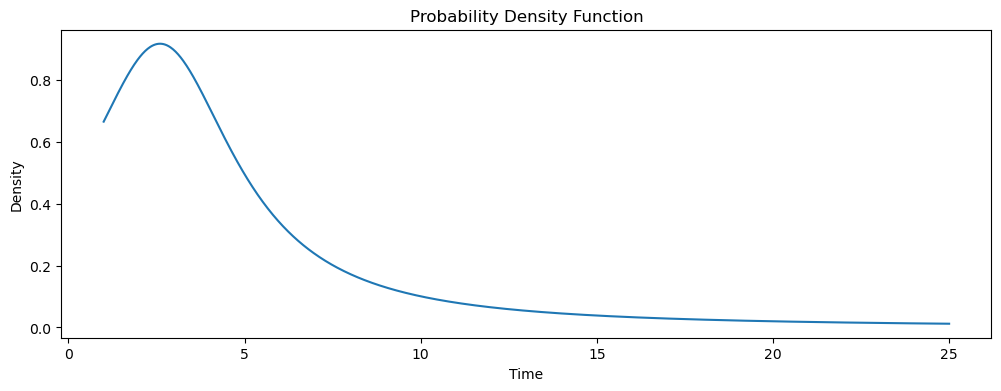

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 2.6
sigma = 2.6
height = 7.5
offset = -2

# Create time points
t = np.linspace(1, 25, 1000)

# Calculate PDF (derivative of CDF)
pdf = (height / (np.pi * sigma)) * (1 / (1 + ((t - mu)/sigma)**2))

# Plot PDF
plt.figure(figsize=(12, 4))
plt.plot(t, pdf)
plt.title('Probability Density Function')
plt.xlabel('Time')
plt.ylabel('Density')


Text(0.02, 0.98, 'Points shown: 10,000\nEntropy range: 0.000 to 5.987')

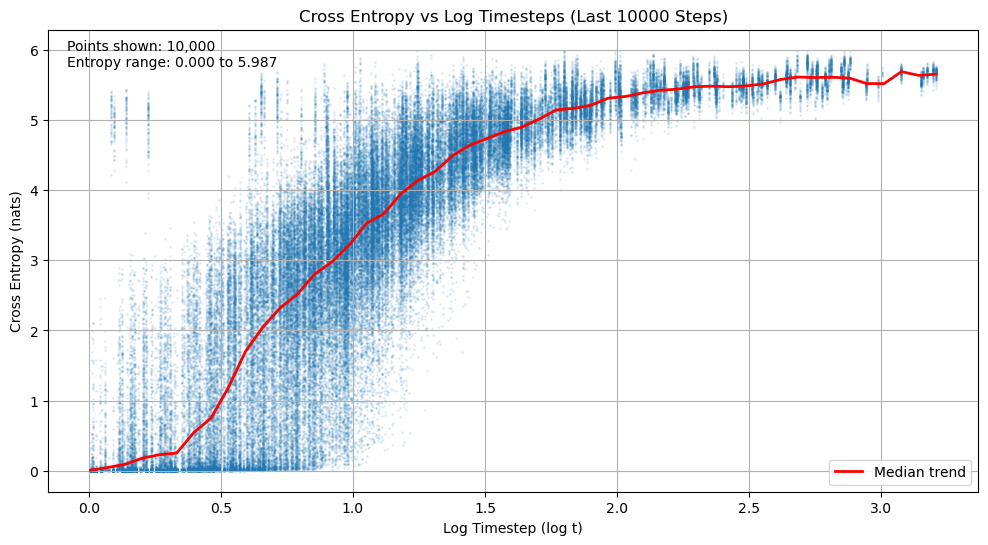

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get last 10000 points
times = np.array(scheduler.times[-100000:])
entropy = np.array(scheduler.entropy[-100000:])

plt.figure(figsize=(12, 6))
plt.scatter(np.log(times), entropy, alpha=0.1, s=1)

# Trend line using log time bins
log_time_bins = np.linspace(np.log(times.min()), np.log(times.max()), 50)
entropy_means = [np.median(entropy[np.abs(np.log(times) - t) < (np.log(times.max())-np.log(times.min()))/50]) for t in log_time_bins]
plt.plot(log_time_bins, entropy_means, 'r-', linewidth=2, label='Median trend')

plt.title('Cross Entropy vs Log Timesteps (Last 10000 Steps)')
plt.xlabel('Log Timestep (log t)')
plt.ylabel('Cross Entropy (nats)')
plt.grid(True)
plt.legend()

plt.text(0.02, 0.98, f'Points shown: 10,000\nEntropy range: {entropy.min():.3f} to {entropy.max():.3f}', 
        transform=plt.gca().transAxes, verticalalignment='top')

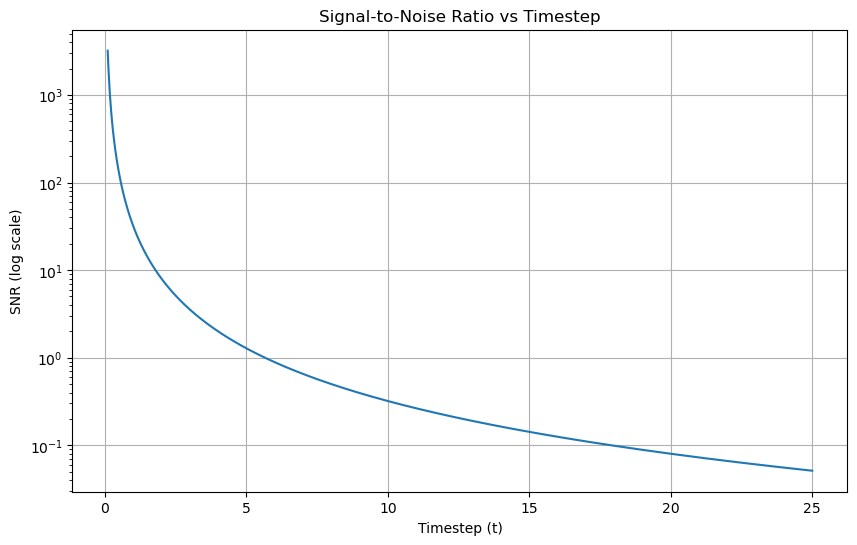

In [14]:
import numpy as np
import matplotlib.pyplot as plt

embed_dim = 32  # typical embedding dimension
t = np.linspace(0.1, 25, 1000)
snr = embed_dim/(t**2)

plt.figure(figsize=(10, 6))
plt.plot(t, snr)
plt.yscale('log')
plt.title('Signal-to-Noise Ratio vs Timestep')
plt.xlabel('Timestep (t)')
plt.ylabel('SNR (log scale)')
plt.grid(True)
plt.show()